# 집값 예측

- Data fields
    - ID : 집을 구분하는 번호 (train set에서만 삭제)
    - zipcode : 우편번호 (삭제)
    - price : 집의 가격(Target variable)
    - date : 집을 구매한 날짜
    - bedrooms : 침실의 수
    - bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
    - floors : 집의 층 수
    - waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    - view : 집이 얼마나 좋아 보이는지의 정도
    - condition : 집의 전반적인 상태  
    - grade : King County grading 시스템 기준으로 매긴 집의 등급   
    - yr_built : 지어진 년도 
    - yr_renovated : 집을 재건축한 년도
    - lat : 위도
    - long : 경도
    - 아래 둘이 합치기
        - sqft_above : 지하실을 제외한 평방 피트(면적)
        - sqft_basement : 지하실의 평방 피트(면적)  
    - 거래일 14년인지 15년인지에 따라 다르게 적용
        - sqft_living : 주거 공간의 평방 피트(면적)
        - sqft_lot : 부지의 평방 피트(면적)
        - sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
        - sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [1]:
# machine learning : train, test set
from sklearn.model_selection import train_test_split

# machine learning : Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [2]:
#root_meam_squared_error
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [3]:
# train data, test data 불러오기
house_train = pd.read_csv("dataset/train.csv", engine = 'python')
house_test = pd.read_csv("dataset/test.csv", engine = 'python')
house = [house_train.copy(), house_test.copy()]
#house_train = house[0]
#house_test = house[1]

In [4]:
# 라벨에대한 정규화는 하지 않는게 맞는듯
#h_max = house_train['price'].max() #train set에서 제일 비싼애들 기준으로 정규화

In [4]:
for i in range(len(house)):
    # house의 id 드랍
    house[i].drop(columns= ['id'], inplace = True)
    # date(구매시기) 데이터 줄여주기 ex) 20141013T000000 -> 20141013 ->2014.1013  
    #(구매와 건축 시기 차이 구할 때 유용)
    house[i]['date'] = [round(int(house[i]['date'].iloc[j][:8])/10000, 4) \
                        for j in range(len(house[i]))]
    # price 정규화 0 < price < 1
    house[0]['price'] = house[0]['price'] #test set에는 price없으니 train set만 정규화

#NAN 존재여부 테스트
for i in range(len(house)):
    test = house[i].isnull().sum().sum()  
    if test == 0:
        print('house[{}] : NAN 데이터 없음.'.format(i))
    else:
        print('house[{}] : NAN 데이터가 {}개 있음.'.format(i, test))
# Nan 없음.

house[0] : NAN 데이터 없음.
house[1] : NAN 데이터 없음.


### #. zipcode : 삭제
- zipcode는 위치와 상관이 없다.
- 같은 zipcode를 가지는 집들 중 (위도, 경도)를 구글 지도에 찍어보면 서로 완전 다른 지역을 나타내고 있다.
- 따라서 zipcode는 무의미한 정보이다.
- 완료 데이터 : house1

In [31]:
# zipcode와 (위도, 경도) 정보 조사
for i in range(len(house)):
    h_zip = house[i][['zipcode', 'lat', 'long']].sort_values(by = ['zipcode'])\
    .reset_index(drop=True).head()
    print(h_zip)

   zipcode      lat     long
0    98001  47.3530 -122.294
1    98001  47.2619 -122.271
2    98001  47.3318 -122.277
3    98001  47.3359 -122.257
4    98001  47.3524 -122.285
   zipcode      lat     long
0    98001  47.3398 -122.286
1    98001  47.2849 -122.251
2    98001  47.2871 -122.287
3    98001  47.3427 -122.274
4    98001  47.3260 -122.273


In [32]:
#zipcode 삭제
house1 = []
for i in range(len(house)):
    house1.append(house[i].drop(columns=['zipcode']))
#house_test.drop(columns=['zipcode'], inplace=True)

### #. sqft_lot, sqft_living 전처리
- 거래일이 14년인 것은 sqft_lot, living을 사용
- 거래일이 15년인 것은 sqft_lot15, living15로 사용
- house2

In [33]:
house1[0].head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,2014.1013,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,2015.0225,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
2,2015.0218,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
3,2014.0627,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819
4,2015.0115,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711


In [34]:
# 'sqft_lot,living15'과 'sqft_lot,living' 중 년도 구분해서 적절한 sqft 적용
house2 = []
for i in range(len(house1)):
    h_2014 = house1[i][house1[i]['date'] < 2015].drop(columns = ['sqft_living15', 'sqft_lot15'])
    h_2015 = house1[i][house1[i]['date'] >= 2015].drop(columns = ['sqft_living', 'sqft_lot'])\
        .rename(columns={'sqft_living15' : 'sqft_living', 'sqft_lot15' : 'sqft_lot'})
    house2.append(pd.concat([h_2015,h_2014],axis=0, sort=False).sort_index())

In [35]:
house2[0].head()

,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living,sqft_lot
0,2014.1013,221900.0,3,1.00,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1180,5650
1,2015.0225,180000.0,2,1.00,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
2,2015.0218,510000.0,3,2.00,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
3,2014.0627,257500.0,3,2.25,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,1715,6819
4,2015.0115,291850.0,3,1.50,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711


### #. sqft_above + sqft_basement
- 전체 평수(sqft_total = sqft_above와 sqft_basement) 계산
- sqft_above와 sqft_basement는 삭제
- 근데 이게 sqft living보다 값이 작아서 뭐가 맞는건지 모르겠음. (추후에 지워야할수도)
- house3

In [36]:
house3 = []
for i in range(len(house2)):
    house3.append(house2[i].copy())
    house3[i]['sqft_total'] = house3[i]['sqft_above']+house3[i]['sqft_basement']
    house3[i].drop(columns = ['sqft_above', 'sqft_basement'], inplace = True)

In [37]:
house3[0].head()

,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated,lat,long,sqft_living,sqft_lot,sqft_total
0,2014.1013,221900.0,3,1.00,1.0,0,0,3,7,1955,0,47.5112,-122.257,1180,5650,1180
1,2015.0225,180000.0,2,1.00,1.0,0,0,3,6,1933,0,47.7379,-122.233,2720,8062,770
2,2015.0218,510000.0,3,2.00,1.0,0,0,3,8,1987,0,47.6168,-122.045,1800,7503,1680
3,2014.0627,257500.0,3,2.25,2.0,0,0,3,7,1995,0,47.3097,-122.327,1715,6819,1715
4,2015.0115,291850.0,3,1.50,1.0,0,0,3,7,1963,0,47.4095,-122.315,1650,9711,1060


### #. yr_built 처리 : 거래당시 집의 연차 계산 + #. yr_renovated 처리 : 재건축 유무로 변경
- 거래당시 지어진지 몇년되었는지 계산.
- round(date,0) - yr_built
- 재건축 유 = 1
- 재건축 무 = 0
- 두가지 년도 관련 전처리 후 데이터 : house4

In [38]:
# 거래당시 집의 연차 계산
house4 = []
for i in range(len(house3)):
    house4.append(house3[i].copy())
    house4[i]['yr_built'] = round(house4[i]['date'], 0) - house4[i]['yr_built']

In [39]:
for i in range(len(house4)):
    house4[i]['yr_renovated'][house4[i]['yr_renovated'] == 0] = 0
    house4[i]['yr_renovated'][house4[i]['yr_renovated'] != 0] = 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
house4[0].head()

,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated,lat,long,sqft_living,sqft_lot,sqft_total
0,2014.1013,221900.0,3,1.00,1.0,0,0,3,7,59.0,0,47.5112,-122.257,1180,5650,1180
1,2015.0225,180000.0,2,1.00,1.0,0,0,3,6,82.0,0,47.7379,-122.233,2720,8062,770
2,2015.0218,510000.0,3,2.00,1.0,0,0,3,8,28.0,0,47.6168,-122.045,1800,7503,1680
3,2014.0627,257500.0,3,2.25,2.0,0,0,3,7,19.0,0,47.3097,-122.327,1715,6819,1715
4,2015.0115,291850.0,3,1.50,1.0,0,0,3,7,52.0,0,47.4095,-122.315,1650,9711,1060


### #. date 전처리 / yr_buit 뒤집기
- 지금의 date 데이터는 2014.1230과 2015.0101사이에 갭이 있다
- date 최솟값 (2014.0502)을 시작으로 월만 더하기 형태로 간다.
- ex) 2014.0502 -> 2014.0502-2014 = 0.0502 -> 5 -> 5 - 4 = 1
- ex) 2015.0102 -> 2015.0102-2015+0.12(2014년의 12달) = 0.1302 -> 13 -> 13-4 = 9
- ..
- yr_built는 지어진지 오래될 수록 큰 값을 가진다.
- 하지만 오래될수록 집값은 떨어진다. 따라서 최근에 지어질 수록 큰값 부여하기. 
- yr_built를 최댓값 기준으로 빼기. = yr_built_inv

In [45]:
house5 = []
# 데이터들 중 처음 거래가 이루어진 날짜
# h_date_min = house4[0]['date'].min()
for i in range(len(house4)):
    house5.append(house4[i].copy())
#     ex) 2014.0502 -> 2014.0502-2014 = 0.0502 -> 5 -> 5 - 4 = 1
#     ex) 2015.0102 -> 2015.0102-2015+0.12(2014년의 12달) = 0.1302 -> 13 -> 13-4 = 9
    #2014년 건에 대한 연산
    house5[i]['date'][house5[i]['date']<2015] \
            = round((house5[i]['date'][house5[i]['date']<2015]-2014)*100,0) - 4
    #2015년 건에 대한 연산
    house5[i]['date'][house5[i]['date']>2015] \
            = round((house5[i]['date'][house5[i]['date']>2015]-2015+0.12)*100,0) - 4


# 거래일로부터 지어진 기간의 최댓값
h_built_max = house4[0]['yr_built'].max()    
for i in range(len(house5)):
    # yr_built를 최댓값 기준으로 빼기 
    # ex) 10.0 -> 115.0(max) - 10.0 = 105.0
    # 즉, 최근에 지어질 수록 큰값 부여.
    house5[i]['yr_built_inv'] = h_built_max - house5[i]['yr_built']
    house5[i].drop(columns = ['yr_built'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [46]:
house5[0].head()

,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_renovated,lat,long,sqft_living,sqft_lot,sqft_total,yr_built_inv
0,6.0,221900.0,3,1.00,1.0,0,0,3,7,0,47.5112,-122.257,1180,5650,1180,56.0
1,10.0,180000.0,2,1.00,1.0,0,0,3,6,0,47.7379,-122.233,2720,8062,770,33.0
2,10.0,510000.0,3,2.00,1.0,0,0,3,8,0,47.6168,-122.045,1800,7503,1680,87.0
3,2.0,257500.0,3,2.25,2.0,0,0,3,7,0,47.3097,-122.327,1715,6819,1715,96.0
4,9.0,291850.0,3,1.50,1.0,0,0,3,7,0,47.4095,-122.315,1650,9711,1060,63.0


### #. 변수 분포가 치우친 것들 정규화

In [48]:
from scipy.stats import norm, skew

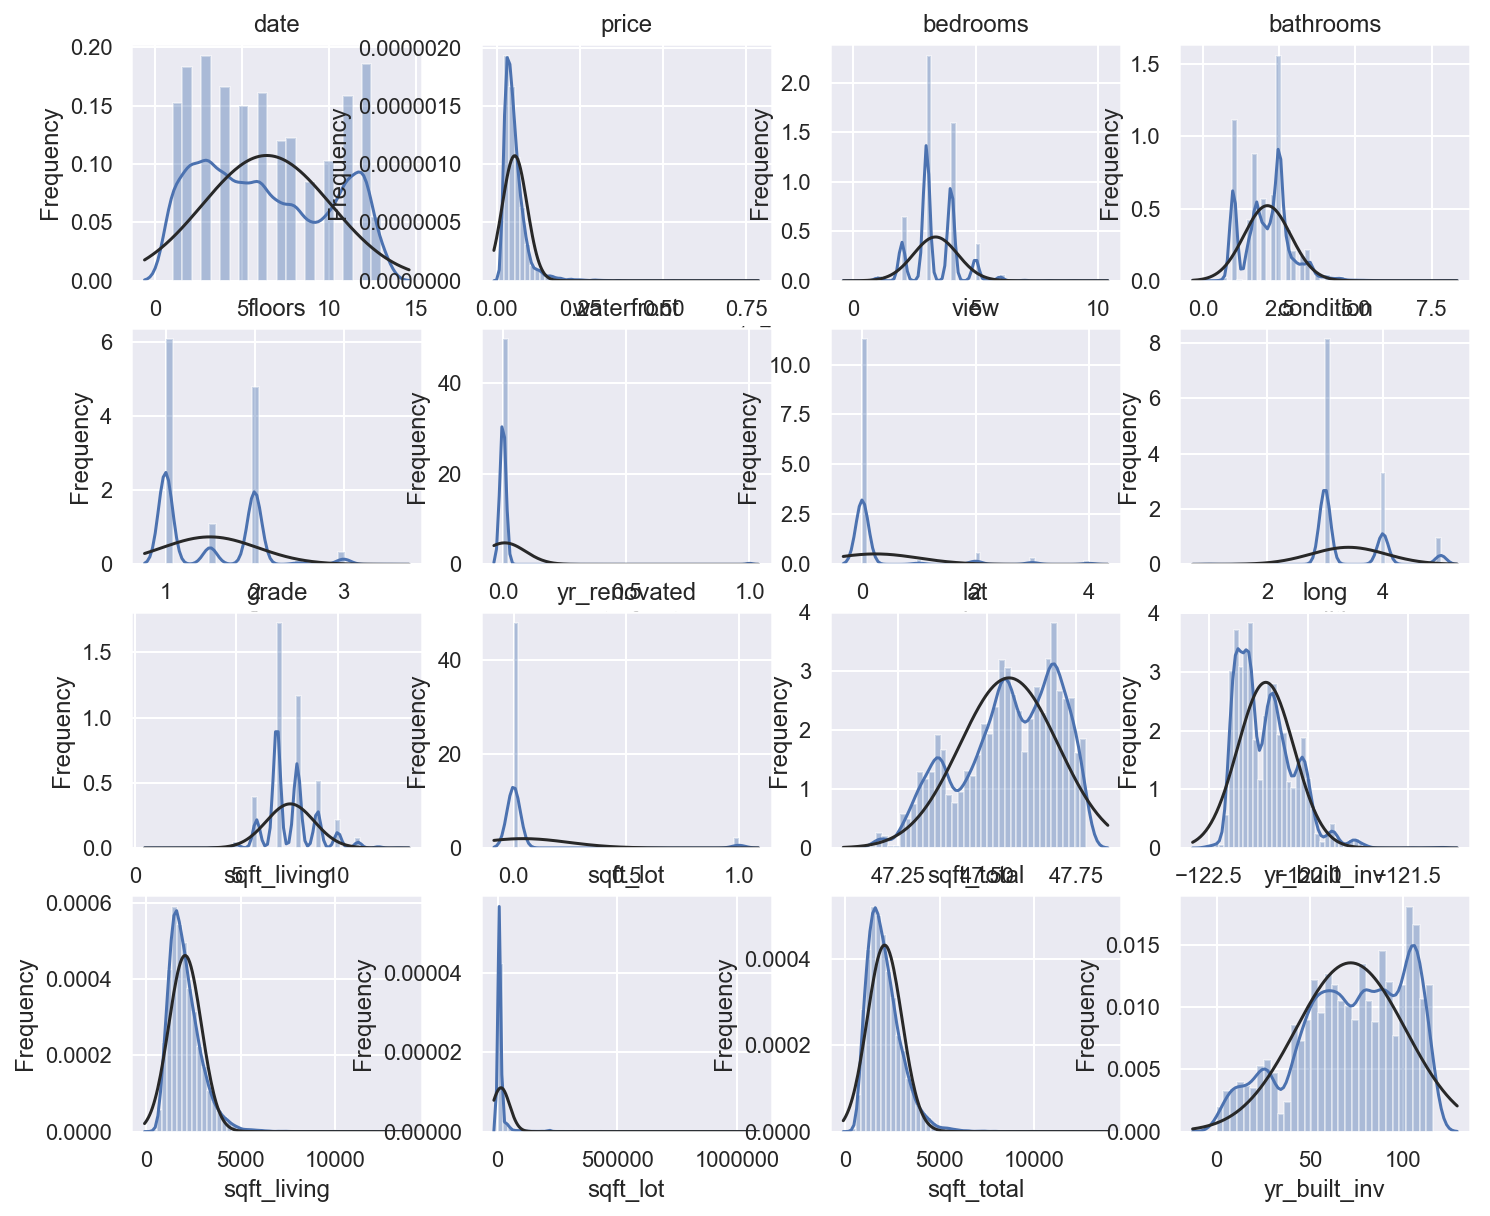

In [49]:
house_target = house5[0]

# let's plot a histogram with the fitted parameters used by the function
col = house_target.columns
fig = plt.figure(figsize=(12, 10))
for i in range(1,17):
    target = house_target[col[i-1]]
    axi = fig.add_subplot(4,4,i)
    sns.distplot(target , fit=norm, ax=axi)
    plt.ylabel('Frequency')
    plt.title(col[i-1]);
#plt.show()

### 예를 들어, price의 치우친 분포를 log scale로 바꿔서 바로 잡는 것

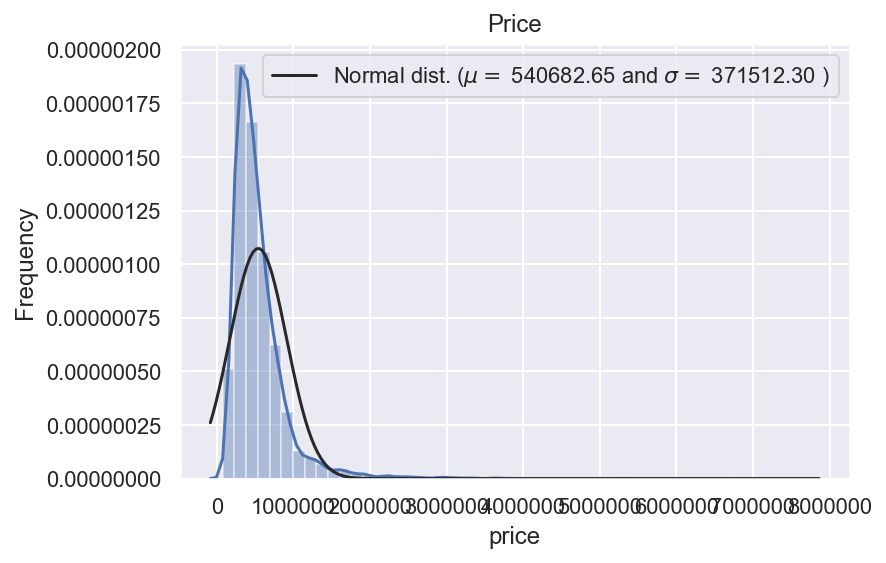

In [50]:
'''
price의 의 분포도를 살펴보면 아래와 같이 왼쪽으로 치우쳐져있다.
'''
target = house5[0]['price']
# let's plot a histogram with the fitted parameters used by the function
sns.distplot(target , fit=norm);
# get mean and standard deviation
(mu, sigma) = norm.fit(target)
# add legends to the plot
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price');

In [51]:
'''
치우친 정도가 4.29로 크진 않지만 시작적으론 심하다.
'''
print("Skewness: %f" % target.skew())

Skewness: 4.290252


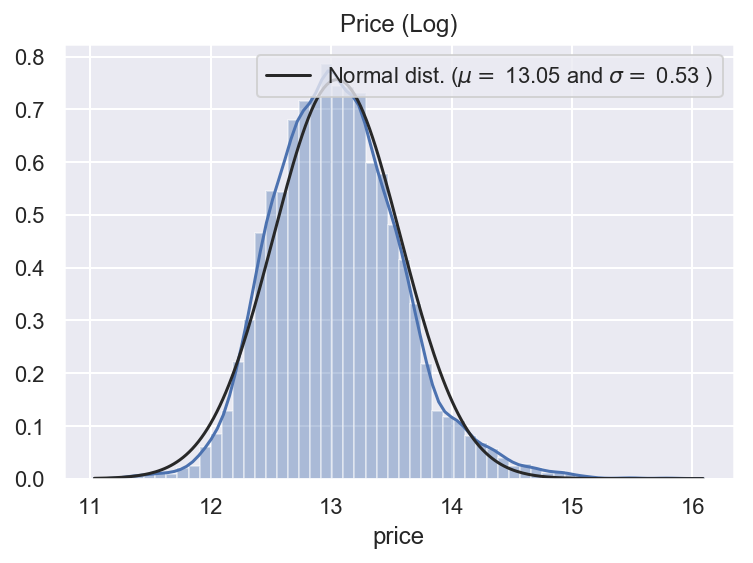

In [52]:
'''
아래와 같이 log로 변환하여 분포를 정규분포화되는 것을 확인한다.
'''
#applying log transformation
target = np.log(target)

# let's plot a histogram with the fitted parameters used by the function
sns.distplot(target , fit=norm);
(mu, sigma) = norm.fit(target)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.title('Price (Log)');

In [53]:
'''
이제 'price' 열의 log 값을 변환해준다.
이 경우 house5[1]은 price정보가 없기 때문에 house5[0]만 변환해준다.
'''
house5[0]['price'] = np.log(house5[0]['price']) 

### 나머지 치우쳐져있는 변수들의 분포 바로잡기

In [54]:
# rescaling
h_long_max = house_train['long'].max()

for i in range(len(house5)):
    house5[i]['sqft_living'] = np.log(house5[i]['sqft_living'])
    house5[i]['sqft_total'] = np.log(house5[i]['sqft_total'])
    house5[i]['sqft_lot'] = np.log(house5[i]['sqft_lot'])
    house5[i]['long'] = house5[i]['long']/h_long_max
    house5[i]['bathrooms'] = np.log(1+house5[i]['bathrooms'])

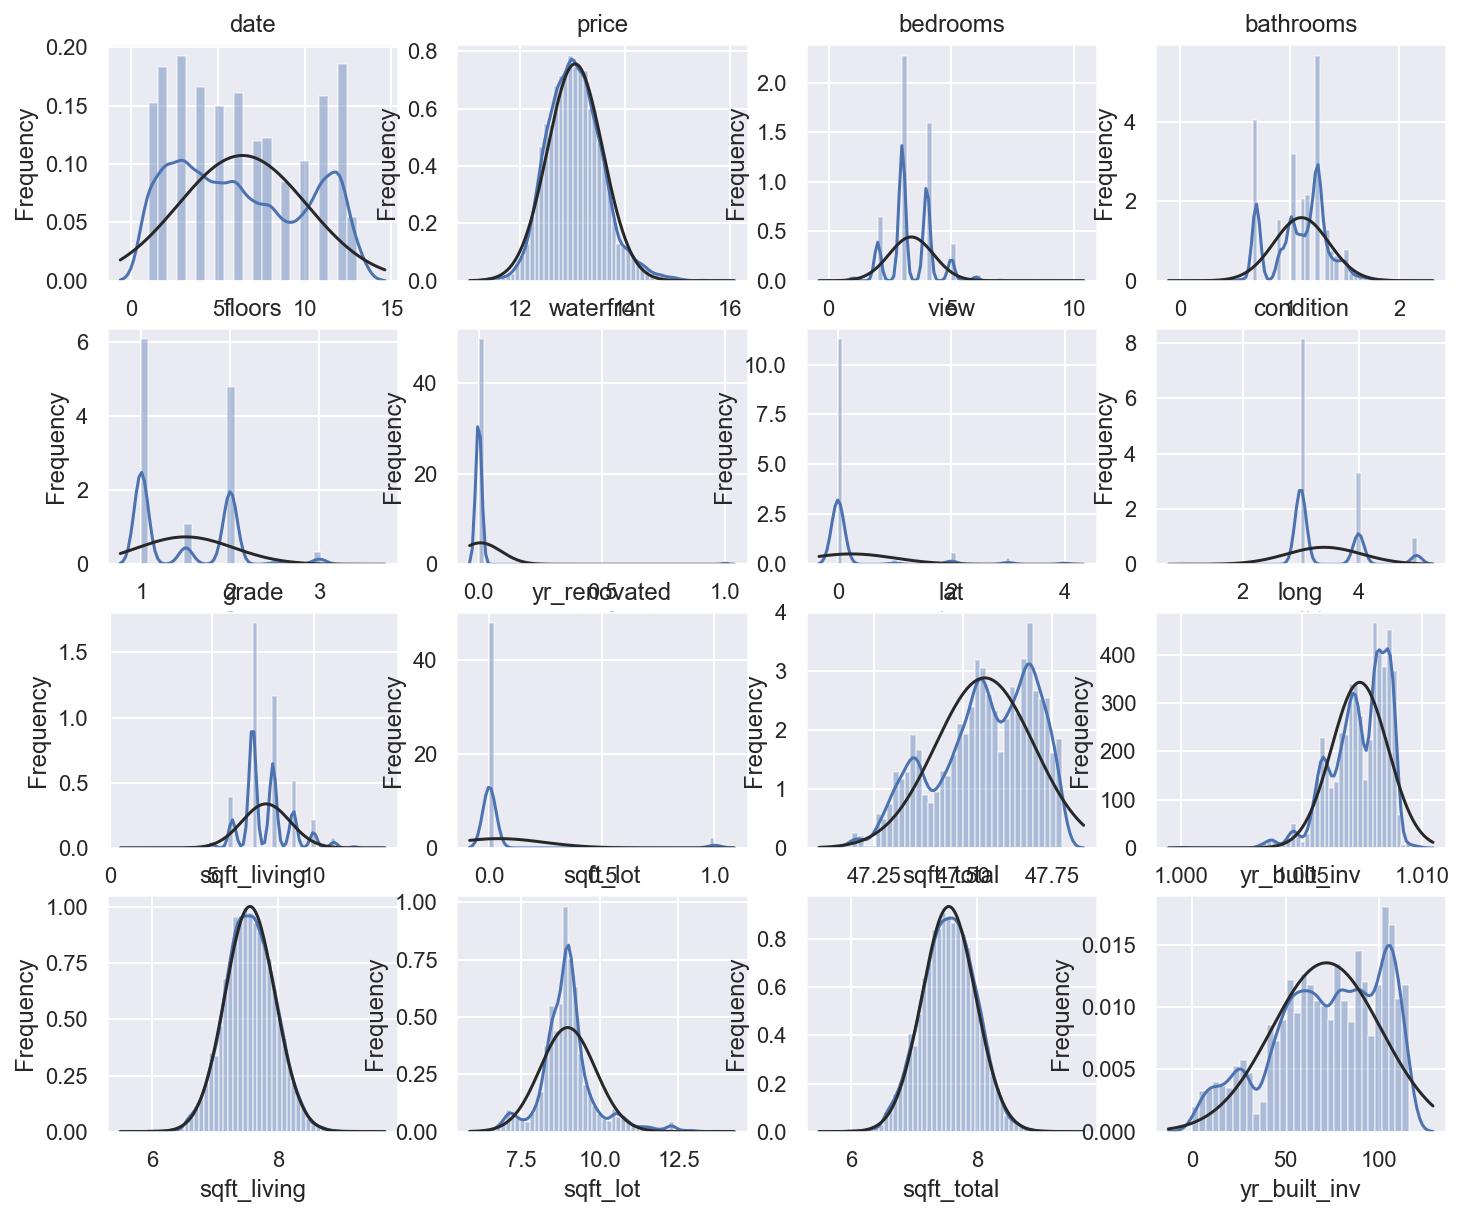

In [55]:
# rescale 처리 후 분포도 
house_target = house5[0]

# let's plot a histogram with the fitted parameters used by the function
col = house_target.columns
fig = plt.figure(figsize=(12, 10))
for i in range(1,17):
    target = house_target[col[i-1]]
    axi = fig.add_subplot(4,4,i)
    sns.distplot(target , fit=norm, ax=axi)
    plt.ylabel('Frequency')
    plt.title(col[i-1]);
#plt.show()

### #. 변수치우침확인

In [56]:
house6 = house5.copy()
# df.skew(): 열별 왜도
biased_condition = abs(house6[0].skew()) > 1.5 # biased_condition : 1.5보다 크면 치우쳤다고 간주함
# biased_variables: 왜도의 절대 값이 1.5보다 큰 변수
biased_variables = house6[0].columns[biased_condition] 
print('Train set(house6[0])의 변수 {}에 치우침이 발생함.'.format(list(biased_variables)))   

Train set(house6[0])의 변수 ['waterfront', 'view', 'yr_renovated']에 치우침이 발생함.


In [24]:
# from sklearn import preprocessing 
# min_max_scalar = preprocessing.MinMaxScaler()

# # test set에 변수치우침을 train set기준으로 한다고 일단 가정.
# #house6[1][biased_variables] = min_max_scalar.fit_transform((house6[1][biased_variables] \
#  #                                                    - house6[1][biased_variables].min())**2)
# house6[0][biased_variables] = min_max_scalar.fit_transform((house6[0][biased_variables] \
#                                                      - house6[0][biased_variables].min())**2)

## #. Features vs price 상관계수 

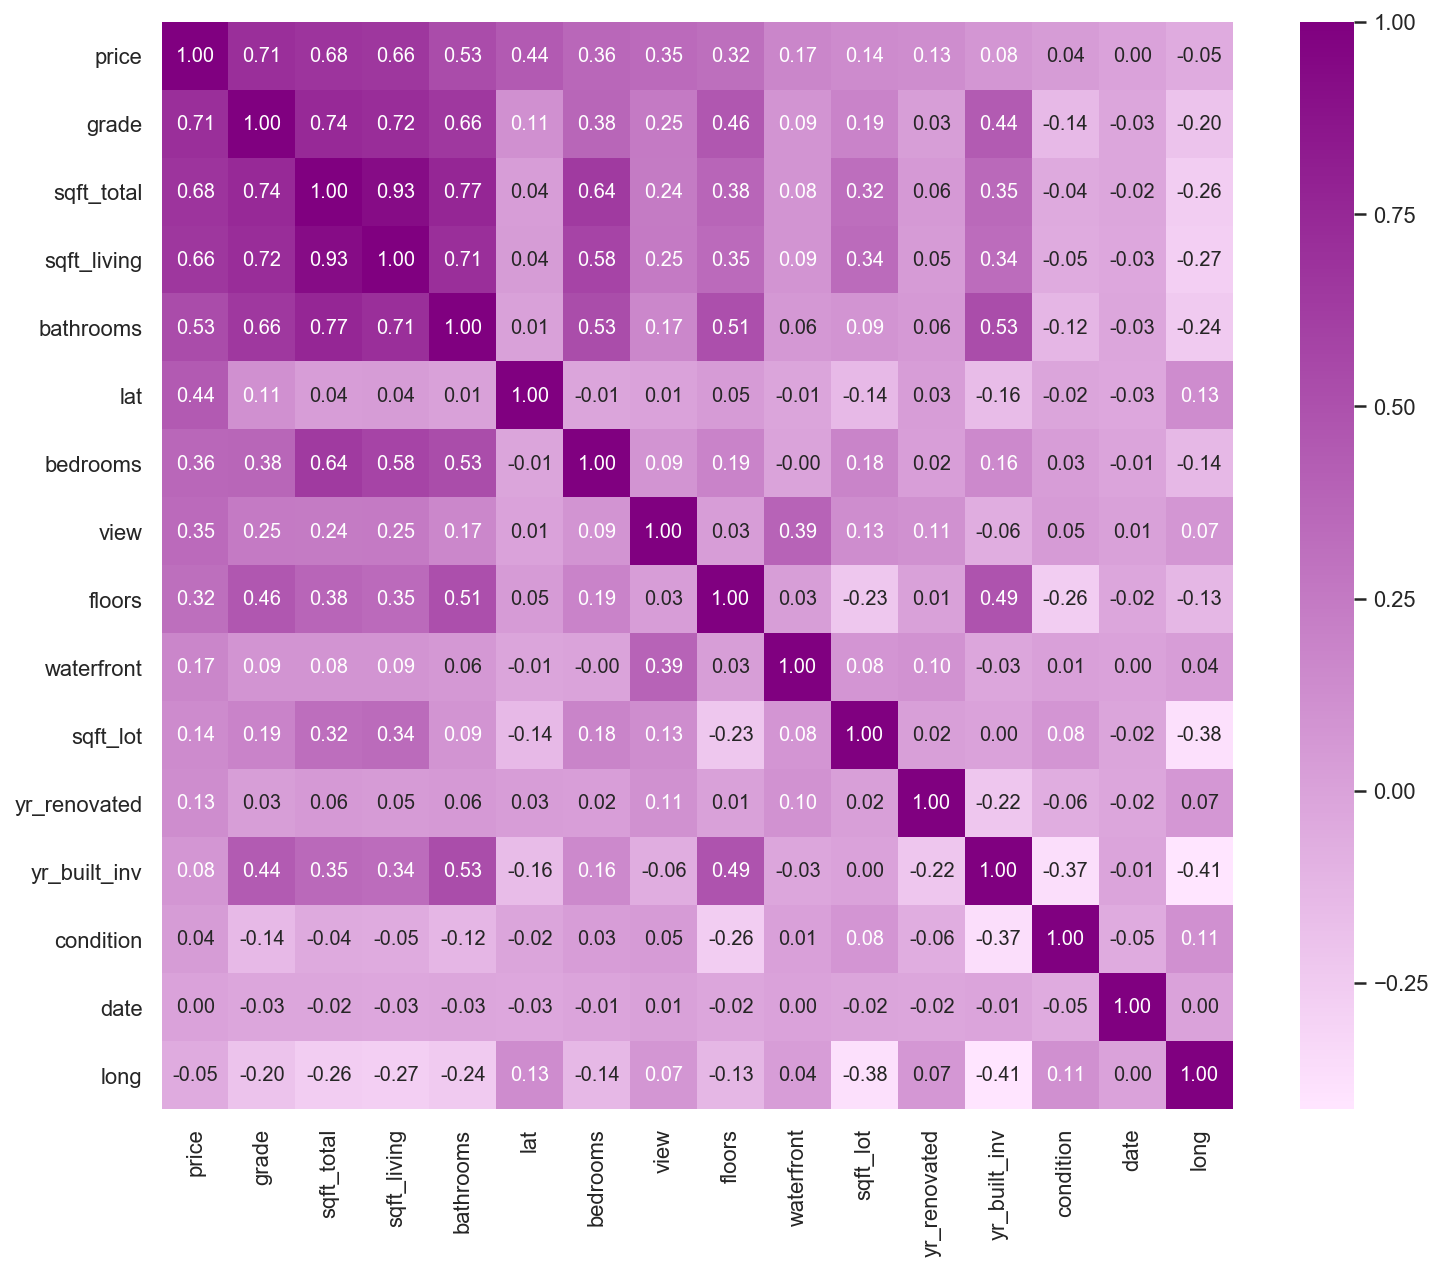

In [62]:
house_corr = house6

# 상관계수 구해서 그래프 그리기.
h_corr1 = house_corr[0].corr(method='pearson').sort_values(by=['price'], ascending=False)\
            .sort_values(by=['price'], axis =1, ascending=False)  
# 상관계수 dataframe /  가격과 상관계수 큰 순으로 정렬(행과 열 모두다 정렬)

#heatmap으로 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(h_corr1, cmap=sns.light_palette("purple", as_cmap=True), annot=True, fmt=".2f")
plt.show()

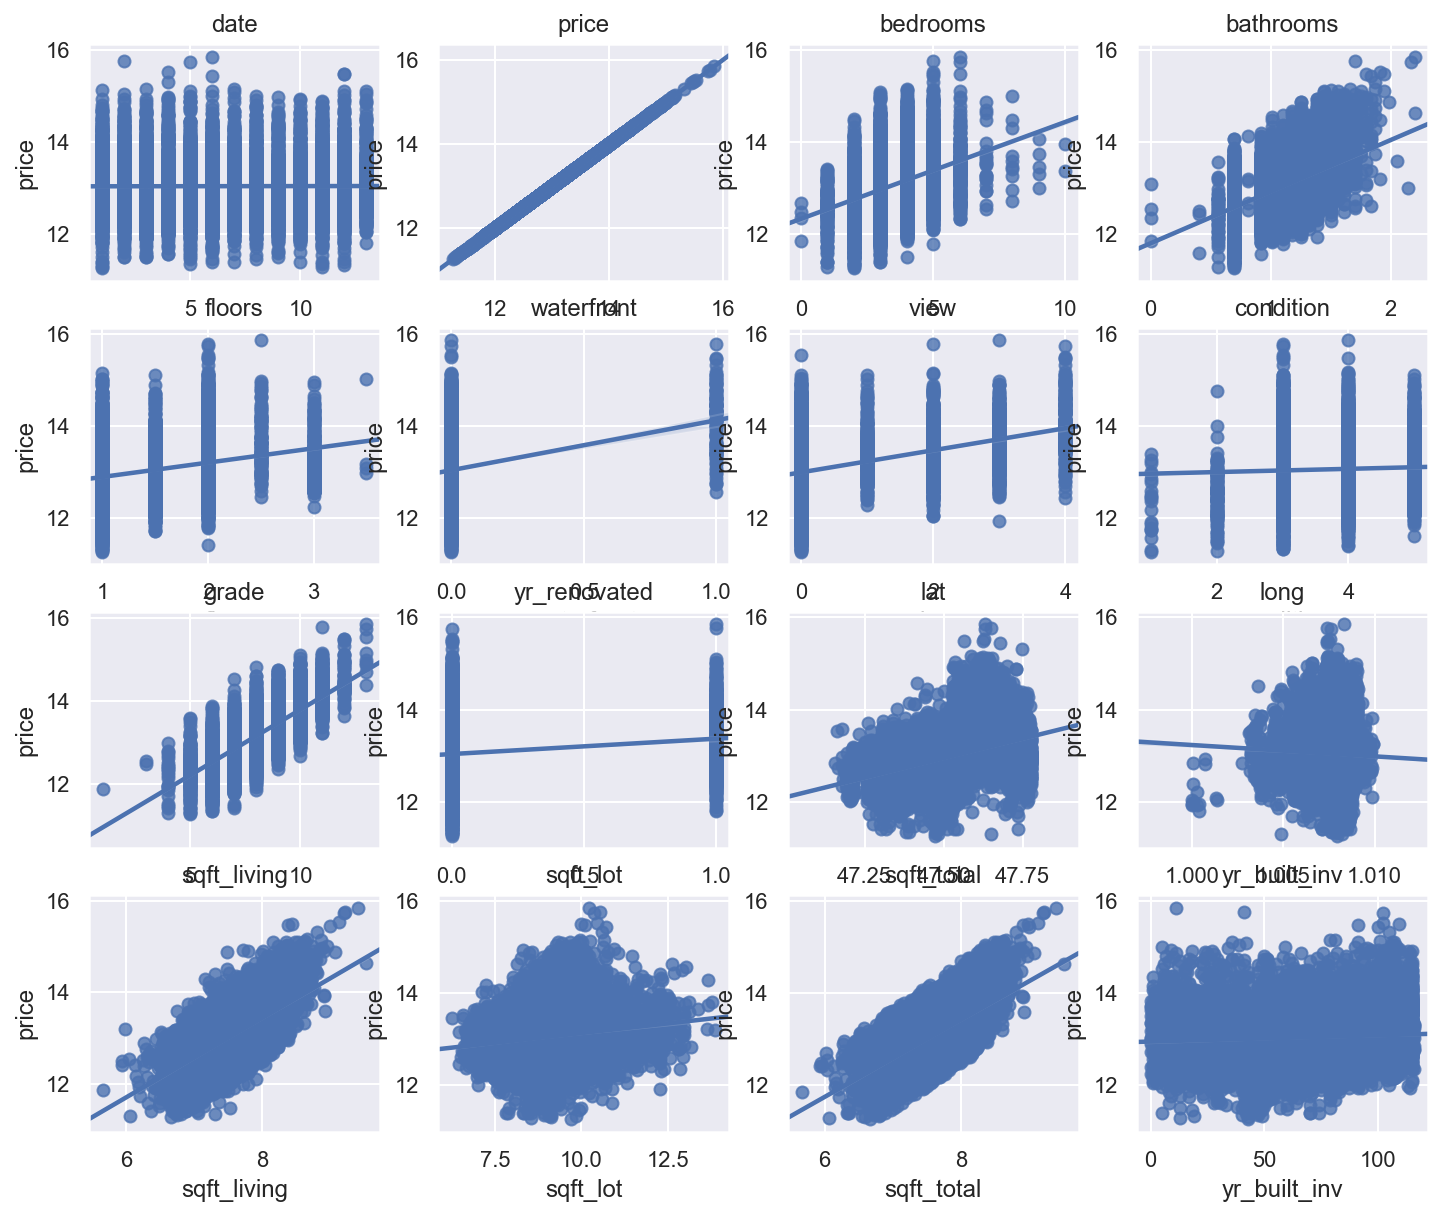

In [61]:
house_target = house6[0]

# columns vs price
col = house_target.columns
fig = plt.figure(figsize=(12, 10))
for i in range(1,17):
    axi = fig.add_subplot(4,4,i)
    sns.regplot(x=col[i-1], y="price", data=house_target)
    plt.title(col[i-1]);

- date는 완전 무관하다.
- yr_built_inv도 무관하다.

In [65]:
# 무관한 변수들을 drop한다
house7 = []
for i in range(len(house6)):
    house7.append(house6[i].drop(columns=['date', 'yr_built_inv']))

In [208]:
# h4_col = list(h_corr1.columns)
# sns.pairplot(house4[0][h4_col], diag_kind = 'auto') 
# #diag_kind : {‘auto’, ‘hist’, ‘kde’}, hue="species" kind="reg"
# plt.show()

# Model Training

## 1. Random Forest

In [85]:
house_model = house7 # 이거만 변경해주면 됨

# 훈련 셋과 평가 셋으로 나누기
Train_X, Test_X, Train_Y, Test_Y \
= train_test_split(house_model[0].drop(columns=['price']), house_model[0]['price'], \
                   test_size=0)
# Test set 정의
submit_X = house_model[1]   # 전처리된 test set
# 유사 정답 세트 가져오기
sample = pd.read_csv("dataset/test_sample.csv")
submit_Y = sample['price']  # 정답 sample로부터 label가져오기, 정규화 안시킴

In [68]:
#random_forest 훈련
print("Train a Random Forest model")
random_forest = RandomForestRegressor(n_estimators=200)#, random_state=2)
random_forest.fit(Train_X, Train_Y)
#예측
Y_pred_forest_test = np.exp(random_forest.predict(submit_X)) #Train_Y의 price가 log scale임

# id + price dataframe 만들기
result_forest = pd.concat([pd.Series(house_test['id']), pd.Series(Y_pred_forest_test, \
                                                           name = 'price')],axis=1)
# root mean squared error
rmse_random_forest = rmse(result_forest['price'], sample['price'])
# accuracy
acc_random_forest = round(random_forest.score(submit_X, np.log(submit_Y)) * 100, 2)
print(rmse_random_forest, acc_random_forest)

Train a Random Forest model
134790.63495133363 88.19


In [97]:
# root mean squared error
rmse_random_forest = rmse(result_forest['price']+14142.4, sample['price'])
# accuracy
acc_random_forest = round(random_forest.score(submit_X, np.log(submit_Y-14142.4)) * 100, 2)
print(rmse_random_forest, acc_random_forest)

134046.66129406658 87.73


In [94]:
(submit_Y.mean() - np.exp(random_forest.predict(submit_X)).mean())

14142.413743688609

ValueError: color kwarg must have one color per data set. 6468 data sets and 1 colors were provided

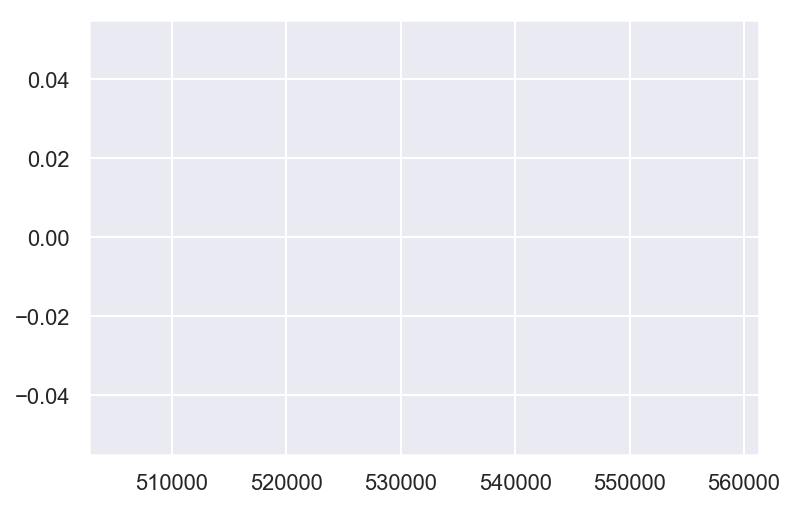

In [104]:
target1 = result_forest['price']
target2 = sample['price']
sns.distplot([target1,target2], fit=norm);
#(mu, sigma) = norm.fit(target)
#plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#            loc='best')
plt.title('Price');

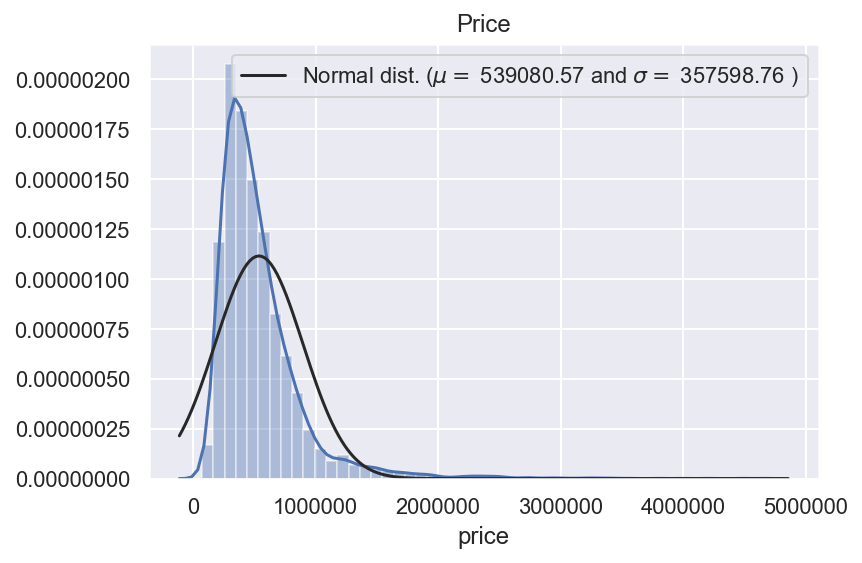

In [99]:
target = sample['price']
sns.distplot(target , fit=norm);
(mu, sigma) = norm.fit(target)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.title('Price');

In [82]:
# train set에서는 잘 맞음
Y_pred_forest_train = np.exp(random_forest.predict(Train_X))
# root mean squared error
rmse_random_forest_train = rmse(Y_pred_forest_train, np.exp(Train_Y))
# accuracy
acc_random_forest_train = round(random_forest.score(Train_X, Train_Y) * 100, 2)
print(rmse_random_forest_train, acc_random_forest_train)

52458.3566765037 98.46


## Random forest optimizing

In [31]:
# hyperparameter optimizing
from sklearn.model_selection import GridSearchCV # Search over specified parameter values for an estimator.
from sklearn.model_selection import RandomizedSearchCV # Search over specified parameter values for an estimator.
from sklearn.model_selection import ShuffleSplit # Random permutation cross-validator

from sklearn.model_selection import train_test_split # import 'train_test_split
from sklearn.ensemble import RandomForestRegressor # import RandomForestRegressor
from sklearn.metrics import r2_score, make_scorer, mean_squared_error # import metrics from sklearn
from time import time

start = time() # Get start time

rf_regressor = RandomForestRegressor(random_state=42) #객체화
cv_sets = ShuffleSplit(random_state = 4) # shuffling our data for cross-validation
parameters = {'n_estimators':[100, 120, 140], 
              'min_samples_leaf':[1, 2, 3], 
              'max_depth':[10,15,20]}
scorer = make_scorer(r2_score)
n_iter_search = 10
grid_obj = RandomizedSearchCV(rf_regressor, 
                              parameters, 
                              n_iter = n_iter_search, 
                              scoring = scorer, 
                              cv = cv_sets,
                              random_state= 99)
grid_fit = grid_obj.fit(Train_X, Train_Y)
rf_opt = grid_fit.best_estimator_

end = time() # Get end time
# Calculate training time
rf_time = (end-start)/60
print('It took {0:.2f} minutes for RandomSearchCV to converge to optimised parameters for the RF model'.format(rf_time))

# Get the estimator best parameters
print(grid_fit.best_params_)

KeyboardInterrupt: 

In [ ]:
# prediction by the optimized random forest
rf_opt_preds = rf_opt.predict(submit_X) # RF predictions
# id + price dataframe 만들기
result_rf_opt = pd.concat([pd.Series(house_test['id']), pd.Series(rf_opt_preds*h_max, \
                                                           name = 'price')],axis=1)
# root mean squared error
rmse_rf_opt = rmse(result_rf_opt['price'], sample['price'])
#accuracy
acc_rf_opt = round(grid_obj.score(submit_X, submit_Y) * 100, 2)
print(acc_rf_opt, rmse_rf_opt)

# 나오는 rmse가 계속 같은걸 보니 여기부터는 데이터 전처리의 문제가 아닌듯. 
# 모델을 바꿔보자